In [25]:
import numpy as np
from scipy.special import expit
import matplotlib as mpl
#mpl.use('TkAgg')
import matplotlib.pyplot as plt
from imageio import imread

%matplotlib notebook

# Questions 1 to 4 - Image Denoising using ICM and Gibbs Sampling in the Ising Model

## Some Helper Functions

### Add noise to image

In [26]:
def add_guassian_noise(im, prop, var_sigma):
    N = int(np.round(np.prod(im.shape) * prop))

    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N], im.shape)
    e = var_sigma * np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] += e[index]

    return im2


def add_saltnpepper_noise(im, prop):
    N = int(np.round(np.prod(im.shape) * prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N], im.shape)
    im2 = np.copy(im)
    im2[index] = 1 - im2[index]

    return im2

### Display im2 (Gaussian noise) and im3 (SnP noise)

<IPython.core.display.Javascript object>


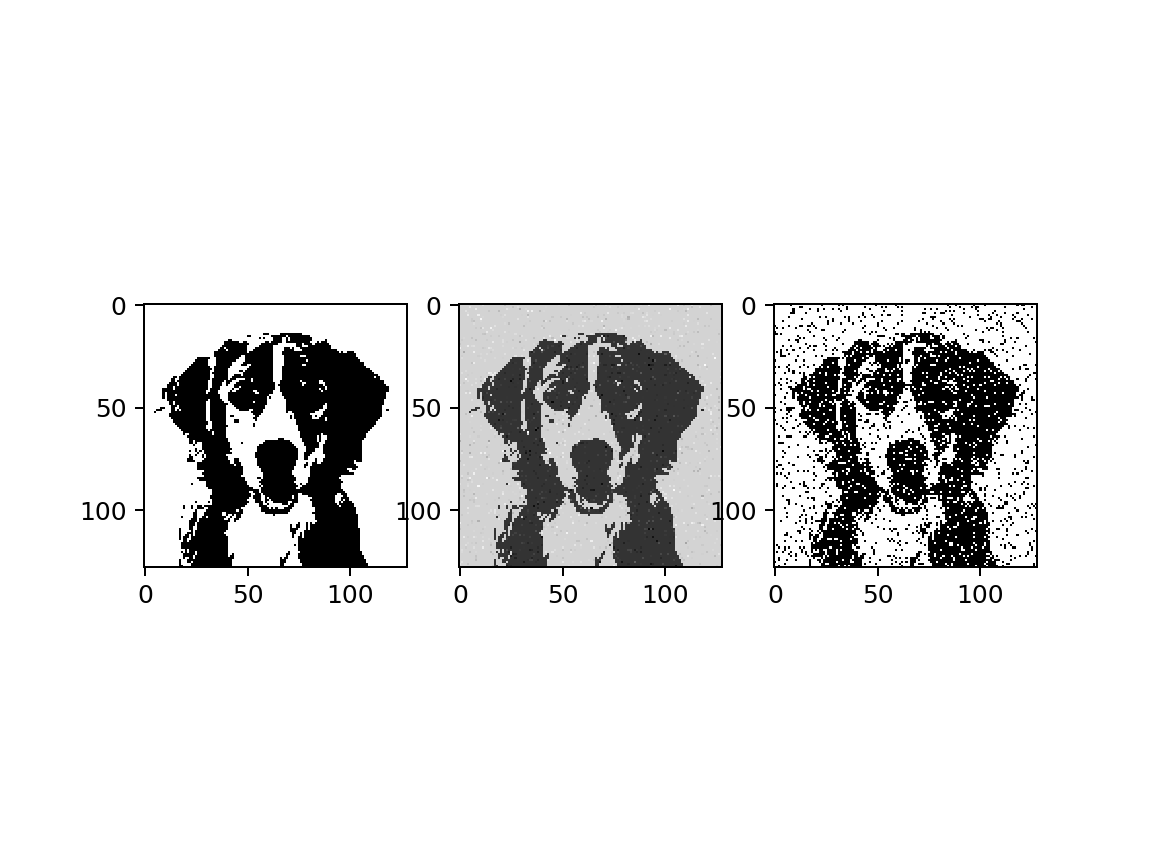

1.0


In [27]:
prop = 0.1
var_sigma = 0.1

im = imread('dog_face_gray.png')
im = im/255
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im, cmap='gray')

print(im[0,0])

im2 = add_guassian_noise(im, prop, var_sigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2, cmap='gray')
im3 = add_saltnpepper_noise(im, prop)
ax3 = fig.add_subplot(133)
ax3.imshow(im3, cmap='gray')


### Neighbours

In [28]:
def neighbours(i, j, M, N, size=4):
    if size == 4:
        # corners
        if i == 0 and j == 0:
            n = [(0, 1), (1, 0)]
        elif i == 0 and j == N - 1:
            n = [(0, N - 2), (1, N - 1)]
        elif i == M - 1 and j == 0:
            n = [(M - 1, 1), (M - 2, 0)]
        elif i == M - 1 and j == N - 1:
            n = [(M - 1, N - 2), (M - 2, N - 1)]

        # edges
        elif i == 0:
            n = [(0, j - 1), (0, j + 1), (1, j)]
        elif i == M - 1:
            n = [(M - 1, j - 1), (M - 1, j + 1), (M - 2, j)]
        elif j == 0:
            n = [(i - 1, 0), (i + 1, 0), (i, 1)]
        elif j == N - 1:
            n = [(i - 1, N - 1), (i + 1, N - 1), (i, N - 2)]

        # everywhere else
        else:
            n = [(i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)]

        return n

## Q1) Recover Latent Image Using ICM

#### parameters

In [29]:
beta = 2
eta = 1.5
h = 0

#### ICM (minimise energy. don't calculate total energy on each iter, just use local energy update)

0
1
2
3
4


<IPython.core.display.Javascript object>


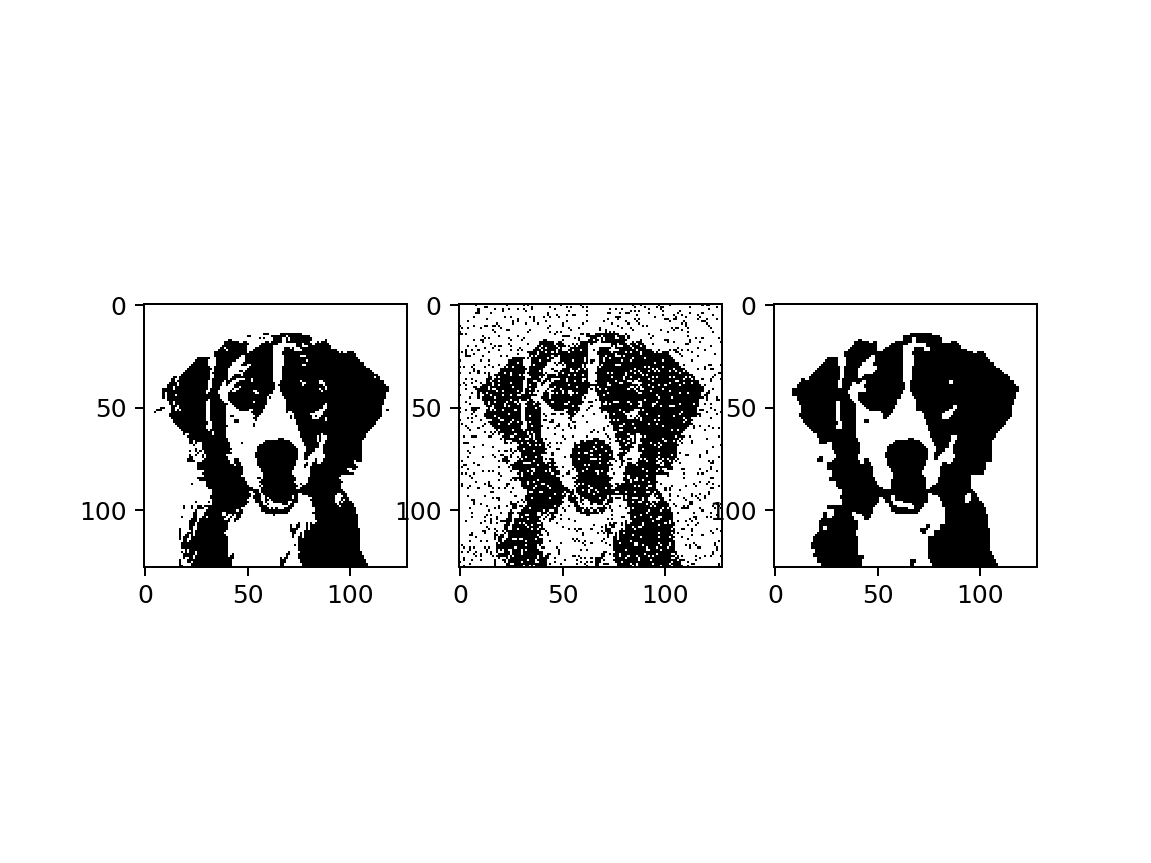

In [30]:
def total_energy(im_latent, im_noisy):
    E = 0.0

    for j in range(im_latent.shape[0]):
        for i in range(im_latent.shape[1]):
            E += h * im_latent[j, i]

            neighs = neighbours(j, i, im_latent.shape[0], im_latent.shape[1])
            E -= beta * sum(im_latent[j, i] * im_latent[neigh_j, neigh_i] for neigh_j, neigh_i in neighs)

            E -= eta * im_latent[j, i] * im_noisy[j, i]

    return E


def local_energy(E1, im_latent, im_noisy, j, i):
    neighs = neighbours(j, i, im_latent.shape[0], im_latent.shape[1])

    original = im_latent[j, i]
    flipped = original * -1

    E2 = E1 - (h * original) + (h * flipped)

    E2 = E2 + beta * sum(original * im_latent[neigh_j, neigh_i] for neigh_j, neigh_i in neighs)
    E2 = E2 - beta * sum(flipped * im_latent[neigh_j, neigh_i] for neigh_j, neigh_i in neighs)

    E2 = E2 + (eta * im_noisy[j, i] * original) - (eta * im_noisy[j, i] * flipped)

    return E1, E2, original, flipped


def icm(image, max_iters):
    im_noisy = np.copy(image)
    im_noisy[im_noisy >= 0.5] = 1
    im_noisy[im_noisy < 0.5] = -1

    im_latent = np.copy(im_noisy)

    E_current = total_energy(im_latent, im_noisy)
    
    for t in range(max_iters):
        
        modified = False
        
        for j in range(im_latent.shape[0]):
            for i in range(im_latent.shape[1]):
                old = im_latent[j, i]
                E1, E2, original, flipped = local_energy(E_current, im_latent, im_noisy, j, i)

                if E1 < E2:
                    im_latent[j, i] = original
                    E_current = E1
                else:
                    im_latent[j, i] = flipped
                    E_current = E2
                
                if old != im_latent[j, i]:
                    modified = True

        print(t)
        if not modified:
            break

    return im_latent

im_out = icm(im2, 1000)
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im, cmap='gray')

ax2 = fig.add_subplot(132)
ax2.imshow(im3, cmap='gray')

ax3 = fig.add_subplot(133)
ax3.imshow(im_out, cmap='gray')

## Q2-4) Recover image using Gibbs Sampling

In [31]:
def init_gibbs3(Y):
    X_0 = np.copy(Y)
    X_0[X_0 >= 0.5] = 1
    X_0[X_0 < 0.5] = -1
    return X_0


def likelihood_part(j, i, X, Y, weight):
    """p(y_i | x_i) = e^L_i(x_i) where L_i large if x_i = y_i else small"""
    
    x_i = X[j, i] + 1 / 2 #scale x_i to be in [0, 1]
    y_i = Y[j, i]
    
    # if x_i=y_i then L_i = 0 (so e^L_i = 1) else L_i < 0 (so e^L_i < 1)
    L_i = - np.abs(x_i - y_i) * weight
    return np.exp(L_i)


def prior_part(j, i, X, M, N, weight):
    """p(x) = product of e^E_0(x)"""
    
    # get the neighbours of x_ij
    neighs = neighbours(j, i, M, N)
    
    # we want to calculate weight * x_pq * x_rs for
    #   x_ij with all neighbours of it ...
    total = 0
    for neigh_j, neigh_i in neighs:
        total += weight * X[j, i] * X[neigh_j, neigh_i]
        
        # ... then for each neighbour, we do the same
        for neigh_jj, neigh_ii in neighbours(neigh_j, neigh_i, M, N):
            total += weight * X[neigh_j, neigh_i] * X[neigh_jj, neigh_ii]
    
    return total
    
    
def posterior_part(j, i, x_value, X, Y, M, N):
    # set X[i, j] to x_value
    X[j, i] = x_value
    
    # calculate likelihood part
    weight = 1
    _likelihood = likelihood_part(j, i, X, Y, weight)
    
    # calculate prior part
    weight = 0.7
    _prior      = prior_part(j, i, X, M, N, weight)
    
    return _likelihood * _prior
    

def gibbs3_ising_posterior(j, i, X, Y, M, N):
    numerator   = posterior_part(j, i, 1, X, Y, M, N)
    denominator = numerator + posterior_part(j, i, -1, X, Y, M, N)
    
    return numerator / denominator
    

def gibbs3(Y, time_steps, burn_in, random=True, use_random_init=False):
    X_t = np.empty_like(Y)
    if use_random_init:
        # init to random values of -1 or 1
        X_t = np.random.rand(X_t.shape[0], X_t.shape[1])
        X_t[X_t >= 0.5] = 1
        X_t[X_t < 0.5]  = -1
    else:
        # init gibbs to a copy of Y set s.t. y_i elem [-1, 1]
        X_t = init_gibbs3(Y)
    
    # get dim(X)
    M = X_t.shape[0] # rows (j)
    N = X_t.shape[1] # cols (i)
    
    # for time_steps iterations
    avg = np.zeros_like(X_t).astype(np.float64)
    for t in range(time_steps + burn_in):
        for itr in range(N*M):
            # choose a node to sample from
            i = j = 0
            if random:
                i = np.floor(np.random.uniform(1, N)).astype(int) # pick a random row ix
                j = np.floor(np.random.uniform(1, M)).astype(int) # pick a random col ix
            else:
                i = itr % N
                j = (itr - i) // N

            # sample from posterior p(x_i = 1 | x_not_i, y)
            prob_t = gibbs3_ising_posterior(j, i, X_t, Y, M, N)
            z = np.random.uniform(0, 1)
            if prob_t > z:
                X_t[j, i] = 1
            else:
                X_t[j, i] = -1
                
            # add to avg if we've finished burning in
            if t > burn_in:
                avg += X_t
    
    return avg / time_steps

#### print images for Gibbs Questions 2-4

In [32]:
im = imread('dog_face_gray.png')
im = im/255

###### Question 2

<IPython.core.display.Javascript object>


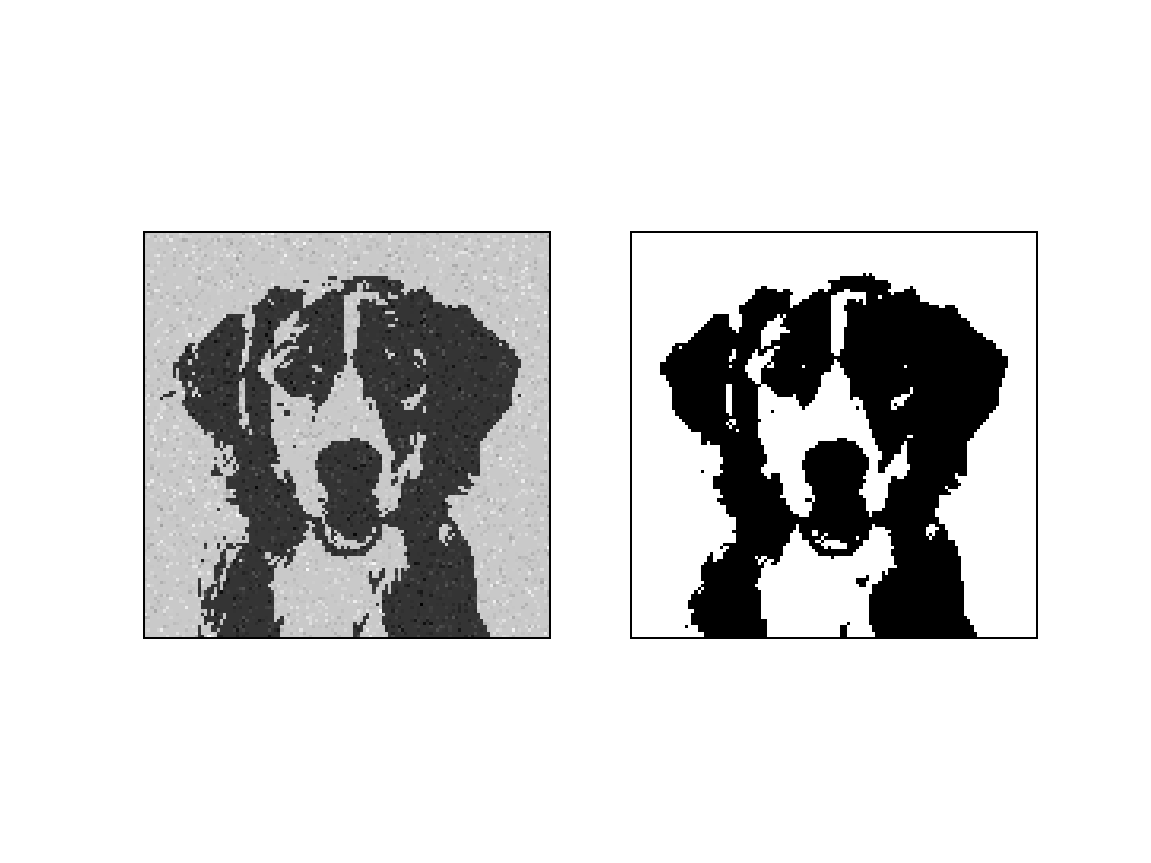

<IPython.core.display.Javascript object>


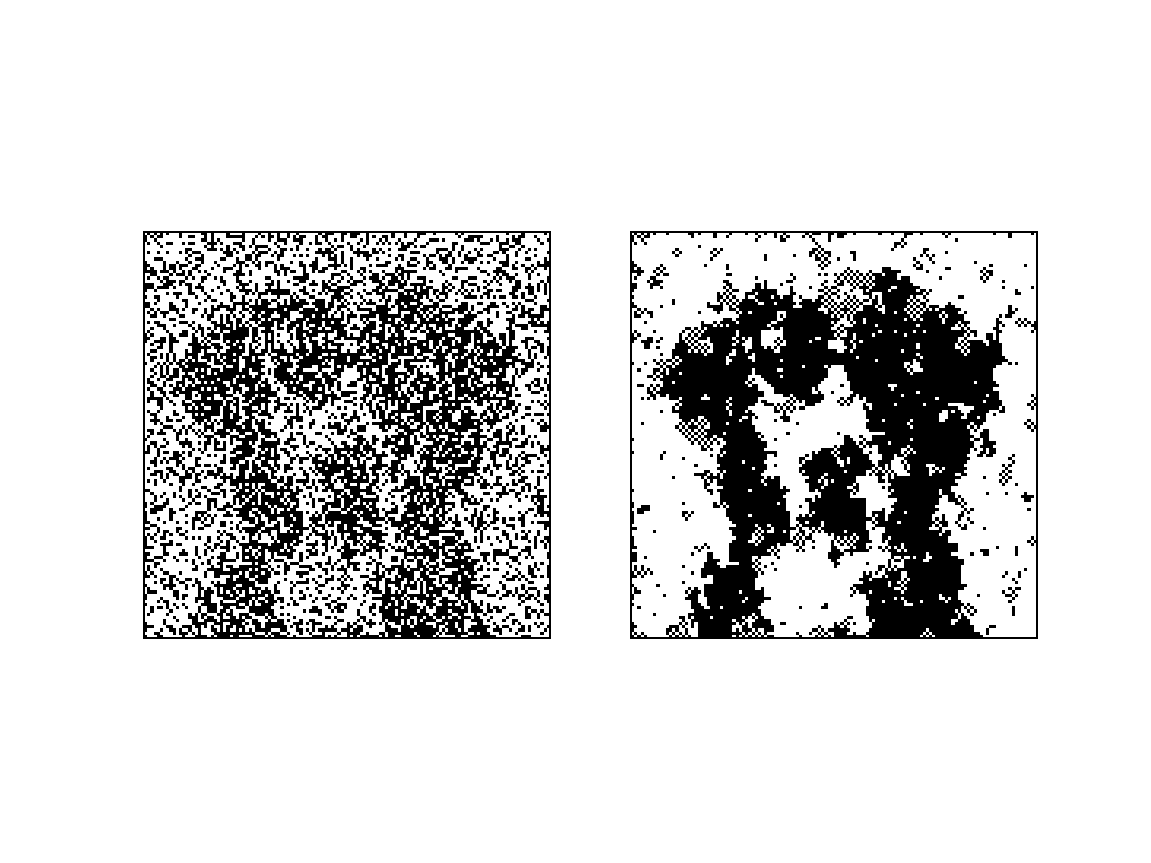

<IPython.core.display.Javascript object>


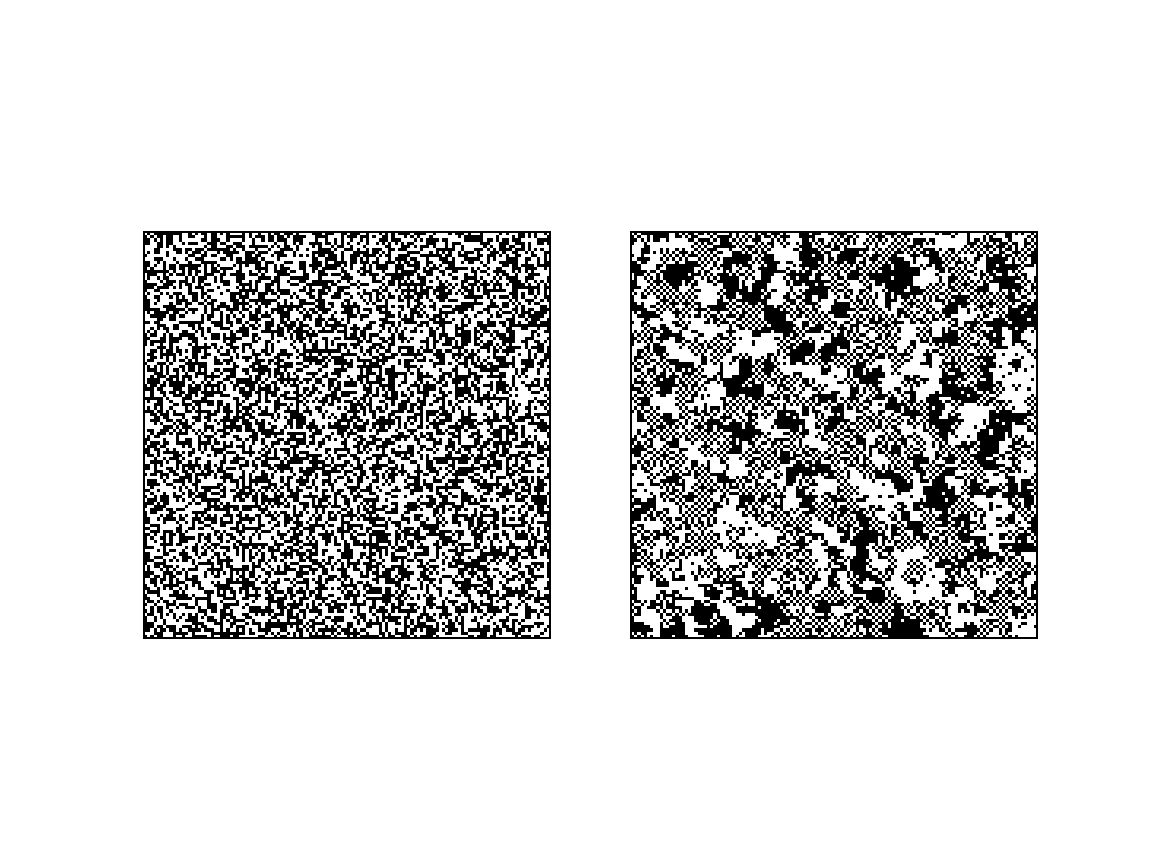

In [33]:
### Question 2 - gibbs, when it works and when it fails?
### plot 10% noisy image which works really well
fig = plt.figure()

prop = 0.3
var_sigma = 0.1
im2 = add_guassian_noise(im, prop, var_sigma)
ax = fig.add_subplot(121)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(im2, cmap='gray')

np.random.seed(42)
im_out = gibbs3(im2, 30, 100)
im_out[im_out >= 0] = 1
im_out[im_out < 0]  = -1
ax = fig.add_subplot(122)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(im_out, cmap='gray')

fig.savefig("gibbs_low_noise.png", bbox_inches = "tight")


### plot 30% saltnpepper image which retains some structure
fig = plt.figure()

prop = 0.33
im2 = add_saltnpepper_noise(im, prop)
ax = fig.add_subplot(121)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(im2, cmap='gray')

np.random.seed(42)
im_out = gibbs3(im2, 30, 100)
im_out[im_out >= 0] = 1
im_out[im_out < 0]  = -1
ax = fig.add_subplot(122)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(im_out, cmap='gray')

fig.savefig("gibbs_mid_noise.png", bbox_inches = "tight")


### plot 50% saltnpepper image which fails
fig = plt.figure()

prop = 0.5
im3 = add_saltnpepper_noise(im, prop)
ax = fig.add_subplot(121)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(im3, cmap='gray')

np.random.seed(42)
im_out = gibbs3(im3, 5, 10)
im_out[im_out >= 0] = 1
im_out[im_out < 0]  = -1
ax = fig.add_subplot(122)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(im_out, cmap='gray')

fig.savefig("gibbs_pure_noise.png", bbox_inches = "tight")


#### Question 3

<IPython.core.display.Javascript object>


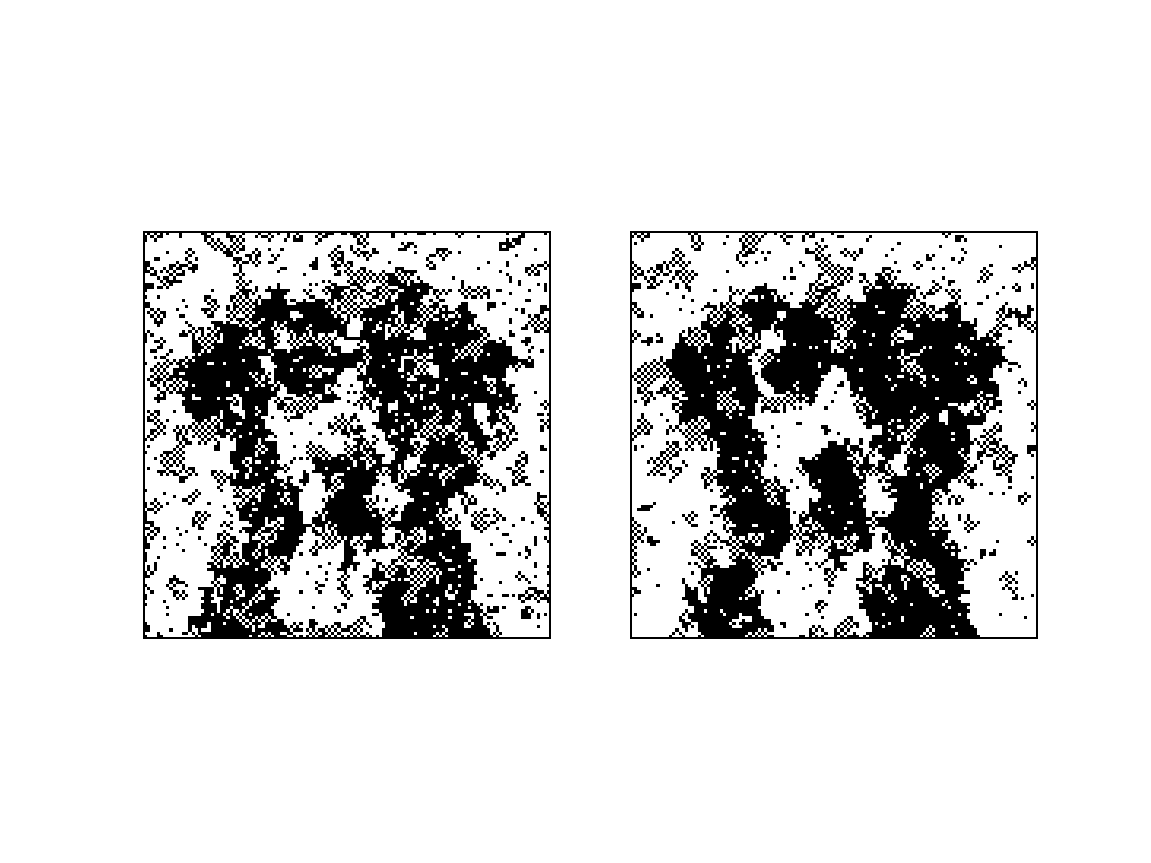

In [34]:
### Question 3 - random vs sequential iter order?
fig = plt.figure()

np.random.seed(42)
im_out = gibbs3(im2, 16, 0)
im_out[im_out >= 0] = 1
im_out[im_out < 0]  = -1
ax = fig.add_subplot(121)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(im_out, cmap='gray')

np.random.seed(42)
im_out = gibbs3(im2, 16, 0, False)
im_out[im_out >= 0] = 1
im_out[im_out < 0]  = -1
ax = fig.add_subplot(122)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(im_out, cmap='gray')

fig.savefig("gibbs_random_vs_seq.png", bbox_inches = "tight")

#### Question 4

<IPython.core.display.Javascript object>


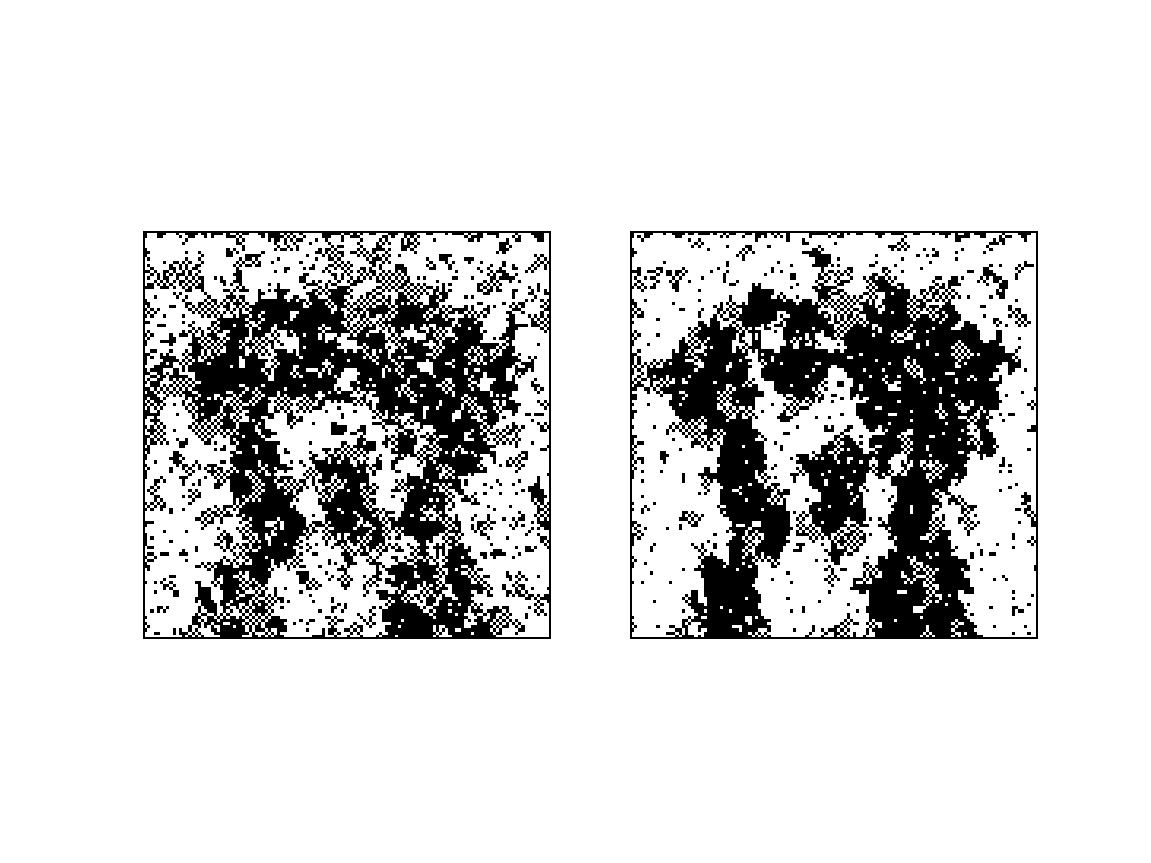

In [35]:
### Question 4 - number of iters
### show without burn-in time for 15 vs 40 iters
### show with burn-in time for 15 iters
fig = plt.figure()

np.random.seed(42)
im_out = gibbs3(im2, 15, 0, True, True)
im_out[im_out >= 0] = 1
im_out[im_out < 0]  = -1
ax = fig.add_subplot(121)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(im_out, cmap='gray')

np.random.seed(42)
im_out = gibbs3(im2, 15, 40, True, True)
im_out[im_out >= 0] = 1
im_out[im_out < 0]  = -1
ax = fig.add_subplot(122)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(im_out, cmap='gray')

fig.savefig("gibbs_differing_iters.png", bbox_inches = "tight")
